# Implement Cats vs Dogs using Vision Transformers

## Using Kaggle API to get dataset

In [ ]:
!pip install kaggle

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp /content/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

  0% 0.00/111k [00:00<?, ?B/s]
100% 111k/111k [00:00<00:00, 41.3MB/s]
100% 271M/271M [00:02<00:00, 99.0MB/s]
100% 271M/271M [00:02<00:00, 108MB/s] 
 97% 527M/544M [00:04<00:00, 126MB/s]
100% 544M/544M [00:04<00:00, 119MB/s]


In [ ]:
pip install vit-pytorch linformer

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt   

from linformer import Linformer   
import glob   
from PIL import Image
from itertools import chain   
from vit_pytorch.efficient import ViT   
from tqdm.notebook import tqdm   
from __future__ import print_function

import torch   
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms   
from torch.optim.lr_scheduler import StepLR   
from torch.utils.data import DataLoader, Dataset

#to unzip the datasets
import zipfile   

from sklearn.model_selection import train_test_split

In [ ]:
os.makedirs('data', exist_ok=True)
train_dir = 'data/train'
test_dir = 'data/test'

#Unzipping dataset
with zipfile.ZipFile('/content/train.zip') as train_zip:
    train_zip.extractall('data')
    
with zipfile.ZipFile('/content/test.zip') as test_zip:
    test_zip.extractall('data')

#Creating train and test list 

train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))

#printing length of the dataset

print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 25000
Test Data: 12500


In [ ]:
#Defining labels

In [ ]:
labels = [path.split('/')[-1].split('.')[0] for path in train_list]

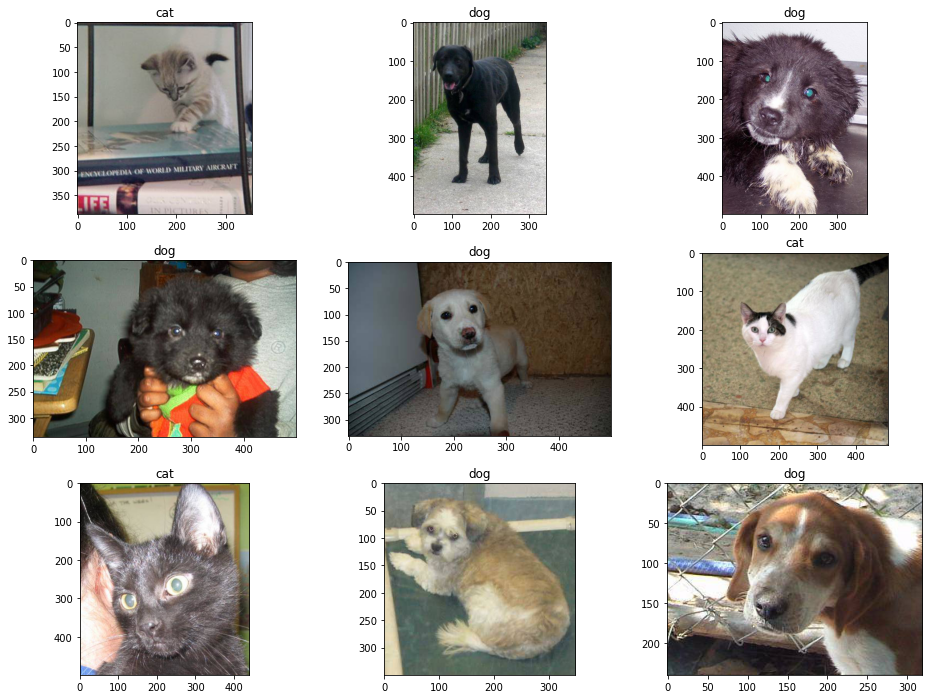

In [ ]:
random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)

In [ ]:
#Splitting train and validation list

train_list, valid_list = train_test_split(train_list, 
                                          test_size=0.2,
                                          stratify=labels,
                                          random_state=1234)
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 20000
Validation Data: 5000
Test Data: 12500


In [ ]:
# Torch transforms

train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)
val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)
test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

In [ ]:
#Loading dataset for training 

class CatsDogsDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        label = img_path.split("/")[-1].split(".")[0]
        label = 1 if label == "dog" else 0
        return img_transformed, label

In [ ]:
#definining batch size, epocs, learning rate and gamma for training  

batch_size = 64
epochs = 20
lr = 3e-5
gamma = 0.7 #for learning rate scheduler 

In [ ]:
#defining train, validation and test dataset

train_data = CatsDogsDataset(train_list, transform=train_transforms)
valid_data = CatsDogsDataset(valid_list, transform=test_transforms)
test_data = CatsDogsDataset(test_list, transform=test_transforms)

train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

In [ ]:
#Line transformer 

efficient_transformer = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [ ]:
#Visual transformer 

model = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=2,
    transformer=efficient_transformer,
    channels=3,
).to(device)


In [ ]:
# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

                            

In [ ]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)
        output = model(data)
        loss = criterion(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)
    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)
            val_output = model(data)
            val_loss = criterion(val_output, label)
            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)
    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )


Epoch : 1 - loss : 0.6955 - acc: 0.5093 - val_loss : 0.6908 - val_acc: 0.5435




Epoch : 2 - loss : 0.6920 - acc: 0.5237 - val_loss : 0.6854 - val_acc: 0.5580




Epoch : 3 - loss : 0.6838 - acc: 0.5557 - val_loss : 0.6749 - val_acc: 0.5860




Epoch : 4 - loss : 0.6747 - acc: 0.5781 - val_loss : 0.6661 - val_acc: 0.5995




Epoch : 5 - loss : 0.6711 - acc: 0.5813 - val_loss : 0.6662 - val_acc: 0.5874




Epoch : 6 - loss : 0.6577 - acc: 0.5993 - val_loss : 0.6448 - val_acc: 0.6191




Epoch : 7 - loss : 0.6492 - acc: 0.6117 - val_loss : 0.6401 - val_acc: 0.6266




Epoch : 8 - loss : 0.6400 - acc: 0.6201 - val_loss : 0.6319 - val_acc: 0.6388




Epoch : 9 - loss : 0.6352 - acc: 0.6229 - val_loss : 0.6453 - val_acc: 0.6161




Epoch : 10 - loss : 0.6247 - acc: 0.6388 - val_loss : 0.6159 - val_acc: 0.6632




Epoch : 11 - loss : 0.6225 - acc: 0.6439 - val_loss : 0.6063 - val_acc: 0.6626




Epoch : 12 - loss : 0.6123 - acc: 0.6551 - val_loss : 0.6212 - val_acc: 0.6475




Epoch : 13 - loss : 0.6054 - acc: 0.6636 - val_loss : 0.6012 - val_acc: 0.6786




Epoch : 14 - loss : 0.6011 - acc: 0.6656 - val_loss : 0.5939 - val_acc: 0.6707




Epoch : 15 - loss : 0.5976 - acc: 0.6728 - val_loss : 0.5924 - val_acc: 0.6764




Epoch : 16 - loss : 0.5968 - acc: 0.6709 - val_loss : 0.6019 - val_acc: 0.6620




Epoch : 17 - loss : 0.5899 - acc: 0.6810 - val_loss : 0.5885 - val_acc: 0.6839




Epoch : 18 - loss : 0.5908 - acc: 0.6777 - val_loss : 0.5957 - val_acc: 0.6818




Epoch : 19 - loss : 0.5889 - acc: 0.6808 - val_loss : 0.5925 - val_acc: 0.6822




Epoch : 20 - loss : 0.5834 - acc: 0.6863 - val_loss : 0.5844 - val_acc: 0.6879

